In [1]:
import networkx as nx
import numpy as np
from itertools import combinations

In [2]:
def ErdosRenyi(N: int, L: int) -> nx.Graph:
    """ ErdosRenyi function generate a graph that contains N
    nodes which are connected with L randomly placed links.
    
    Args:
        N (int): Number of nodes.
        L (int): Number of links to place on the graph.

    Returns:
        nx.Graph: Erdos Renyi random graph (N,L)
    """
    G = nx.Graph()
    G.add_nodes_from(range(N))
    if N == 1:
        """ If only one node then no lines could be created"""
        return G
    
    max_edges = N * (N - 1) / 2
    if L >= max_edges:
        """ Return complete graph"""
        G.add_edges_from(
            [[n1, n2] for n1 in range(N) for n2 in range(N)]
        )
        return G
    
    no_edges = 0
    while(no_edges < L):
        n1, n2 = np.random.choice(N, size=2, replace=False)
        if not G.has_edge(n1, n2):
            G.add_edge(n1, n2)
            no_edges += 1
    return G

In [6]:
def Gilbert(N: int, p: float) -> nx.Graph:
    """ Gilbert creates a Gilberts graph with N nodes.
    
    Args:
        N (int): Number of nodes.
        p (float): Probability of creating a link.

    Returns:
        nx.Graph: Gilbert random graph (N,p)
    """
    G = nx.Graph()
    G.add_nodes_from(range(N))
    # For each pair without repetitions try to create a link
    for v, w in combinations(G.nodes(), 2):
        prob = np.random.random()
        if prob < p:
            G.add_edge(v, w)
    return G

In [28]:
def WattsStrogatz(N: int, k: int, b: float) -> nx.Graph:
    """ WattsStrogatz creates random graphs. At first creates 
    ring over N nodes, where each has k nearest neighbours.
    Then with probability b each link is rewired. It will 
    be considered only even k.
    """
    if k >= N:
        raise ValueError("'k' parameter is to  big.")
    if k % 2 != 0:
        print("Odd k, we will consider k={}".format(k-1))
        
    G = nx.Graph()
    nodes = list(range(N))
    # Create ring with k nearest.
    for j in range(1, k // 2 + 1):
        neighbours = nodes[j:] + nodes[0:j]
        G.add_edges_from(zip(nodes, neighbours))
        
    # rewire edges
    for i in range(1, k // 2 + 1):
        neighbours = nodes[i:] + nodes[0:i]
        for n1, n2 in zip(neighbours, nodes):
            if np.random.random() < b:
                # choose random node
                n3 = np.random.choice(nodes)
                while n3 == n1 or G.has_edge(n1, n3):
                    # if the link already exists try different one
                    n3 = np.random.choice(nodes)
                else:
                    G.remove_edge(n1, n2)
                    G.add_edge(n1, n3)
    return G

In [29]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

## Extract needed values from the graphs and put to pandas DataFrame

In [43]:
ER = ErdosRenyi(100, 500)
Gilb = Gilbert(100, 0.1)
WS = WattsStrogatz(100, 10, 0.5)
# ER = nx.gnm_random_graph(100,500)
# Gilb = nx.fast_gnp_random_graph(100, 0.1)
# WS = nx.watts_strogatz_graph(100, 10, 0.5)

nodes = pd.DataFrame(columns=["node", "degree", "graph"])
ER_nodes = pd.DataFrame(
    [dict(node=node, degree=deg, graph="Erdos-Renyi") for node, deg in ER.degree()]
)
Gilb_nodes = pd.DataFrame(
    [dict(node=node, degree=deg, graph="Gilbert") for node, deg in Gilb.degree()]
)
WS_nodes = pd.DataFrame(
    [dict(node=node, degree=deg, graph="Watts-Strogatz") for node, deg in WS.degree()]
)
nodes = nodes.append([ER_nodes, Gilb_nodes, WS_nodes])

## Degree distribution

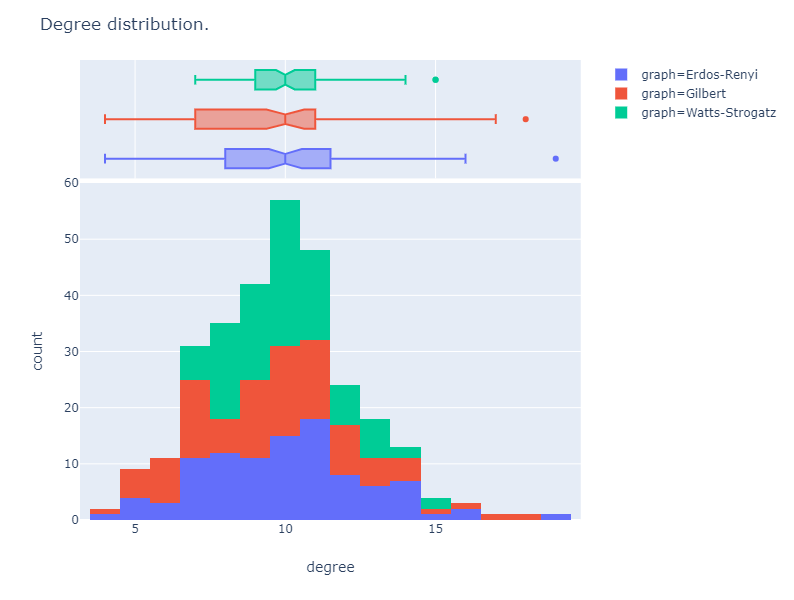

In [46]:
fig = px.histogram(
    nodes,
    x="degree",
    color="graph",
    nbins=nodes.degree.max(),
    marginal="box",
)
fig.update_layout(title="Degree distribution.")
fig.show()

In [39]:

ER_cc = pd.DataFrame(
    [dict(node=node, clust_coef=cc, graph="Erdos-Renyi") for node, cc in nx.algorithms.clustering(ER).items()]
)
Gilb_cc = pd.DataFrame(
    [dict(node=node, clust_coef=cc, graph="Gilbert") for node, cc in nx.algorithms.clustering(Gilb).items()]
)
WS_cc = pd.DataFrame(
    [dict(node=node, clust_coef=cc, graph="Watts-Strogatz") for node, cc in nx.algorithms.clustering(WS).items()]
)
ccoef = ER_cc.append([Gilb_cc, WS_cc])

## Clustering coefficient distribution

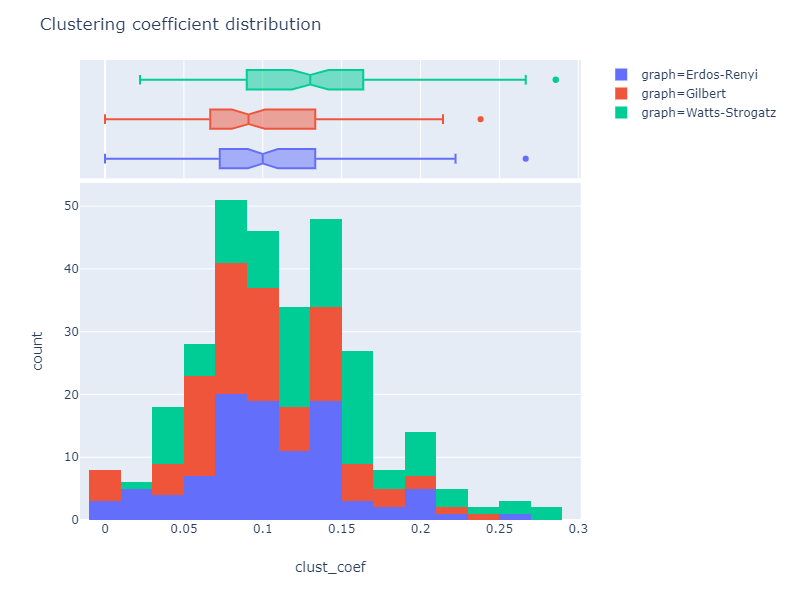

In [47]:
fig = px.histogram(
    ccoef,
    x="clust_coef",
    color="graph",
    marginal="box",
)
fig.update_layout(title="Clustering coefficient distribution")
fig.show()

## Shortest path distribution

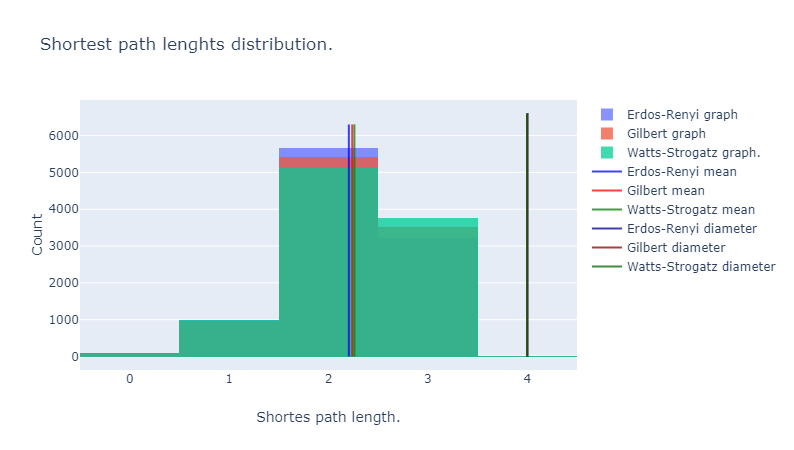

In [48]:
def extract_shortest_paths_lengths(G: nx.Graph) -> list:
    path_lengths = [] 
    for l in nx.shortest_path_length(G):
        path_lengths.extend(l[1].values())
    return path_lengths

# Get list of shortest paths
ER_shortest = extract_shortest_paths_lengths(ER)
Gilb_shortest = extract_shortest_paths_lengths(Gilb)
WS_shortest = extract_shortest_paths_lengths(WS)
    
fig = go.Figure()
# Add histograms
fig.add_trace(
    go.Histogram(
        x=ER_shortest,
        name="Erdos-Renyi graph",
    )
)
fig.add_trace(
    go.Histogram(
        x=Gilb_shortest,
        name="Gilbert graph"
    )
)
fig.add_trace(
    go.Histogram(
        x=WS_shortest,
        name="Watts-Strogatz graph."
    )
)
# Add means 
ER_sp_mean = sum(ER_shortest)/len(ER_shortest)
Gilb_sp_mean = sum(Gilb_shortest)/len(Gilb_shortest)
WS_sp_mean = sum(WS_shortest)/len(WS_shortest)
fig.add_trace(
    go.Scatter(
        x=[
            ER_sp_mean,
            ER_sp_mean,
        ],
        hovertext="mean: {}".format(ER_sp_mean),        
        y = [0, 6300],
        mode="lines",
        line_color="Blue",
        name="Erdos-Renyi mean"
    )
)
fig.add_trace(
    go.Scatter(
        x=[
            Gilb_sp_mean,
            Gilb_sp_mean,
        ],
        hovertext="mean: {}".format(Gilb_sp_mean),
        y = [0, 6300],
        mode="lines",
        line_color="Red",
        name="Gilbert mean"
    )
)
fig.add_trace(
    go.Scatter(
        x=[
            WS_sp_mean,
            WS_sp_mean,
        ],
        hovertext="mean: {}".format(WS_sp_mean),
        y = [0, 6300],
        mode="lines",
        line_color="Green",
        name="Watts-Strogatz mean"
    )
)
# add diameters
fig.add_trace(
    go.Scatter(
        x=[
            max(ER_shortest),
            max(ER_shortest),
        ],
        hovertext="diameter: {}".format(WS_sp_mean),
        y = [0, 6600],
        mode="lines",
        line_color="DarkBlue",
        name="Erdos-Renyi diameter"
    )
)
fig.add_trace(
    go.Scatter(
        x=[
            max(Gilb_shortest),
            max(Gilb_shortest),
        ],
        hovertext="diameter: {}".format(WS_sp_mean),
        y = [0, 6600],
        mode="lines",
        line_color="DarkRed",
        name="Gilbert diameter"
    )
)
fig.add_trace(
    go.Scatter(
        x=[
            max(WS_shortest),
            max(WS_shortest),
        ],
        hovertext="diameter: {}".format(WS_sp_mean),
        y = [0, 6600],
        mode="lines",
        line_color="DarkGreen",
        name="Watts-Strogatz diameter"
    )
)
fig.update_layout(
    title_text="Shortest path lenghts distribution.",
    xaxis_title_text="Shortes path length.",
    yaxis_title_text="Count",
    barmode='overlay',
)

fig.update_traces(opacity=0.75)
fig.show()

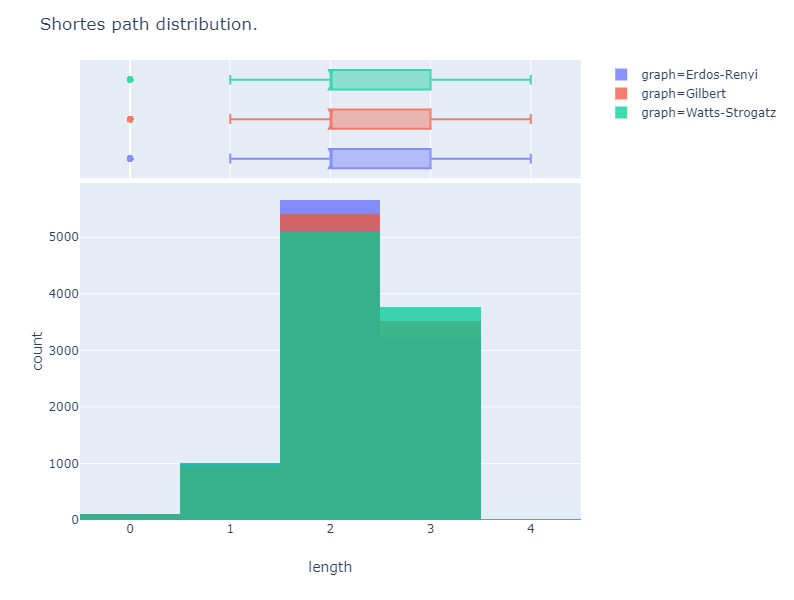

In [50]:
ER_sp = pd.DataFrame(
    [dict(length=length, graph="Erdos-Renyi") for length in ER_shortest]
)
Gilb_sp = pd.DataFrame(
    [dict(length=length, graph="Gilbert") for length in Gilb_shortest]
)
WS_sp = pd.DataFrame(
    [dict(length=length, graph="Watts-Strogatz") for length in WS_shortest]
)
short_paths = ER_sp.append([Gilb_sp, WS_sp])
fig = px.histogram(
    short_paths,
    x="length",
    color="graph",
    marginal="box",
)
fig.update_layout(barmode="overlay", title="Shortes path distribution.")
fig.update_traces(opacity=0.75)
fig.show()